# Exploring RNNs

In this assignment, you will be asked to modify the [notebook](https://colab.research.google.com/drive/1Ge7HNinj0riX56ayukvbVpKpg-BFgni0?usp=sharing) which we went over in class exploring the use of RNNs.

We begin by donwloading and unziping the dataset.

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip

--2021-11-10 01:43:13--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.53, 99.86.37.37, 99.86.37.116, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.18MB/s    in 0.4s    

2021-11-10 01:43:14 (6.18 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


## Loading and Formatting the Data

We provide helper functions for loading the data, and store it as a dictionary with entries for each nationality. Data is split into training and test as well.

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch

# This function returns the path of the files in the dataset
def findFiles(path): return glob.glob(path)

# Specifying list of characters
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# This function converts unicode to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Function for reading afile and splitting into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Specifying percentage of data used for training
perTrain = 0.9

# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_test = {}
all_categories = []

# Loading all the data
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines[0:int(perTrain*len(lines))]
    category_lines_test[category] = lines[int(perTrain*len(lines)):]

# Specifying the number of categories
n_categories = len(all_categories)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

## [Task 1] Using Adam Optimizer [30 pts]

We will be replacing the implementation of standard gradient descent in the baseline model by a call of the Adam optimizer. Do the following:

1. [12 pts] Train the baseline model with the standard gradient descent and a version using Adam optimizer. Plot the learning curves for both approaches. Train both models for only 50,000 iterations.
2. [12 pts] Evaluate the performance of both models on the test set.
3. [6 pts] Comment on the performance of both methods on the test set, and the shape of their learning curves.


### Task 1.1

In [50]:
#helper functions for sampling data.
import random

# Converting a prediction to category labels    
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# Random selection of an entry in a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Randomly selecting a category and then a name from the list
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# Helper function for tracking time ellapsed
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
    
# Showing some examples of randomly selected categories and names
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Greek / line = Papadelias
category = German / line = Switzer
category = Polish / line = Jaskulski
category = Italian / line = Bove
category = English / line = Clayton
category = Arabic / line = Sabbagh
category = Scottish / line = Hughes
category = Korean / line = Hong
category = Vietnamese / line = Phung
category = Korean / line = Lim 


In [51]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.g = nn.Linear(input_size + hidden_size, hidden_size)
        self.f = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.g(combined)
        output = self.f(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128


In [52]:

# Specifying our criterion to match the last prediction layer for the model
criterion = nn.CrossEntropyLoss()

# Defining the learning rate
learning_rate = 0.005 
# Specify optimizer

# Function performing one step of backpropagation
def train(rnn, optimizer, category_tensor, line_tensor):
    
    optimizer.zero_grad()
    hidden = rnn.initHidden()
    #rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    #for p in rnn.parameters():
    #    p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [53]:
rnn_SGD_1 = RNN(n_letters, n_hidden, n_categories)
optimizer_SGD_1 = optim.SGD(rnn_SGD_1.parameters(), learning_rate)
import time
import math

# Specifying the number of gradient decent 
n_iters = 50000

# Specifying some other variables for display of the output
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses_SGD_1 = []
all_iterCt_SGD_1 = []

# Getting the start time
start = time.time()

for iter in range(1, n_iters + 1):
    # Training using a random name and accumulating the loss
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn_SGD_1, optimizer_SGD_1, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
            timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_SGD_1.append(current_loss / plot_every)
        all_iterCt_SGD_1.append(iter)
        current_loss = 0


5000 10% (0m 4s) 2.9214 Williamson / Russian ✗ (Scottish)
10000 20% (0m 8s) 1.5389 Adalardi / Italian ✓
15000 30% (0m 13s) 3.4833 Haanrade / Japanese ✗ (Dutch)
20000 40% (0m 17s) 0.7745 Quang / Vietnamese ✓
25000 50% (0m 22s) 1.7109 Chu / Chinese ✗ (Korean)
30000 60% (0m 26s) 1.3350 Lucassen / Dutch ✓
35000 70% (0m 31s) 1.7622 Redman / Irish ✗ (English)
40000 80% (0m 35s) 3.5214 Piskus / Greek ✗ (Russian)
45000 90% (0m 40s) 0.4138 Sartini / Italian ✓
50000 100% (0m 44s) 0.7255 Romao / Portuguese ✓


In [8]:
rnn_Adam_1 = RNN(n_letters, n_hidden, n_categories)
optimizer_Adam_1 =  optim.Adam(rnn_Adam_1.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
import time
import math

# Specifying the number of gradient decent 
n_iters = 50000

# Specifying some other variables for display of the output
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses_Adam_1 = []
all_iterCt_Adam_1 = []

# Getting the start time
start = time.time()

for iter in range(1, n_iters + 1):
    # Training using a random name and accumulating the loss
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn_Adam_1, optimizer_Adam_1, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
            timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_Adam_1.append(current_loss / plot_every)
        all_iterCt_Adam_1.append(iter)
        current_loss = 0


5000 10% (0m 5s) 2.6925 Abarca / English ✗ (Spanish)
10000 20% (0m 11s) 1.5283 Shin / Chinese ✗ (Korean)
15000 30% (0m 17s) 0.2163 Georgeakopoulos / Greek ✓
20000 40% (0m 23s) 1.5819 Muzylev / Russian ✓
25000 50% (0m 29s) 1.1868 Atyasov / Russian ✓
30000 60% (0m 35s) 1.9111 Casales / Portuguese ✗ (Spanish)
35000 70% (0m 41s) 3.2648 Raskop / Greek ✗ (German)
40000 80% (0m 46s) 1.9786 Mendelsohn / Czech ✗ (German)
45000 90% (0m 52s) 1.3334 Hafner / German ✓
50000 100% (0m 58s) 0.8155 Hamidullin / Russian ✓


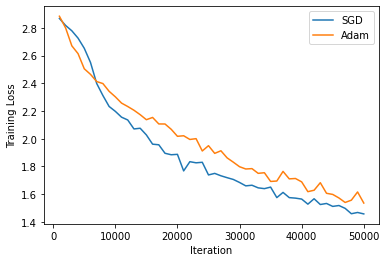

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_iterCt_SGD_1,all_losses_SGD_1,all_iterCt_Adam_1,all_losses_Adam_1)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend(['SGD','Adam'])
plt.show()

### Task 1.2

In [10]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed

# Just return an output given a line
def evaluate(rnn,line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

Average Macro Accuracy = 0.41



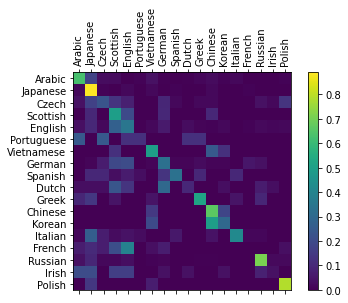

In [11]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# Go through a bunch of examples and record which are correctly guessed
for category in all_categories:
    for line in category_lines_test[category]:
        line_tensor = lineToTensor(line)
        output = evaluate(rnn_SGD_1,line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
accuracy = 0
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    accuracy += confusion[i][i]
accuracy /= n_categories

# Displaying the average accuracy
print('Average Macro Accuracy = {:.2f}\n'.format(accuracy))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Average Macro Accuracy = 0.37



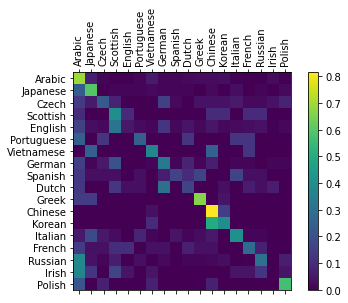

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# Go through a bunch of examples and record which are correctly guessed
for category in all_categories:
    for line in category_lines_test[category]:
        line_tensor = lineToTensor(line)
        output = evaluate(rnn_Adam_1,line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
accuracy = 0
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    accuracy += confusion[i][i]
accuracy /= n_categories

# Displaying the average accuracy
print('Average Macro Accuracy = {:.2f}\n'.format(accuracy))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Task 1.3

TO DO - Enter Your Response here

1) The performance of SGD on testset with learning rate = 0.005 was better ADAM with learning rate= 0.0001.

2) SGD has a steeper learning curve when compared with ADAM.





## [Task 2] Implementing a More Complex RNN [30 pts]

Replace the linear layer $g$ in the baseline model by a two-layer fully connected neural network with ReLU activation. The new subnetwork should implement:

$$h^{(t)} = g(c^{(t)}) = \sigma\left(W_2 \cdot \sigma \left(W_1 \cdot c^{(t)} + b_1 \right) + b_2 \right),$$

where $\sigma$ is a ReLU activation, and $(W_k,b_k)$ are the parameters for a linear layer. Then, answer the following:

1. [12 pts] Compare the learning curves for the baseline trained with Adam and this more complex model trained with Adam as well. Train both models for only 50,000 iterations.
2. [12 pts] Evaluate the performance of both models on the test set.
3. [6 pts] Comment on the performance of both methods on the test set, and the shape of their learning curves.


### Task 2.1

In [13]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_2, self).__init__()

        self.hidden_size = hidden_size

        self.g1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.g2 = nn.Linear(hidden_size, hidden_size)
        self.f = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = F.relu(self.g2(F.relu(self.g1(combined))))
        output = self.f(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128


In [14]:
rnn_Adam_2 = RNN_2(n_letters, n_hidden, n_categories)
optimizer_Adam_2 =  optim.Adam(rnn_Adam_2.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
import time
import math

# Specifying the number of gradient decent 
n_iters = 50000

# Specifying some other variables for display of the output
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses_Adam_2 = []
all_iterCt_Adam_2 = []

# Getting the start time
start = time.time()

for iter in range(1, n_iters + 1):
    # Training using a random name and accumulating the loss
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(rnn_Adam_2, optimizer_Adam_2, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
            timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses_Adam_2.append(current_loss / plot_every)
        all_iterCt_Adam_2.append(iter)
        current_loss = 0

5000 10% (0m 11s) 1.4433 O'Callaghann / Irish ✓
10000 20% (0m 23s) 0.2593 Thach / Vietnamese ✓
15000 30% (0m 35s) 0.5549 Ilyunin / Russian ✓
20000 40% (0m 47s) 3.2835 Japaskurt / Dutch ✗ (Russian)
25000 50% (0m 59s) 2.2349 Han / Chinese ✗ (Korean)
30000 60% (1m 11s) 0.1279 Ferreira / Portuguese ✓
35000 70% (1m 23s) 0.1557 Grygarova / Czech ✓
40000 80% (1m 35s) 0.0042 Bahar / Arabic ✓
45000 90% (1m 47s) 0.7572 Pawlak / Czech ✓
50000 100% (1m 59s) 0.0078 Stamatelos / Greek ✓


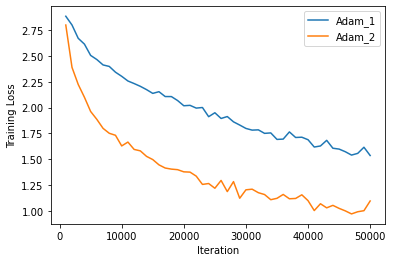

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_iterCt_Adam_1,all_losses_Adam_1,all_iterCt_Adam_2,all_losses_Adam_2)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend(['Adam_1','Adam_2'])
plt.show()

### Task 2.2


Average Macro Accuracy = 0.37



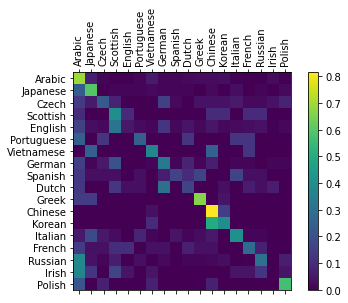

In [17]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# Go through a bunch of examples and record which are correctly guessed
for category in all_categories:
    for line in category_lines_test[category]:
        line_tensor = lineToTensor(line)
        output = evaluate(rnn_Adam_1,line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
accuracy = 0
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    accuracy += confusion[i][i]
accuracy /= n_categories

# Displaying the average accuracy
print('Average Macro Accuracy = {:.2f}\n'.format(accuracy))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Average Macro Accuracy = 0.47



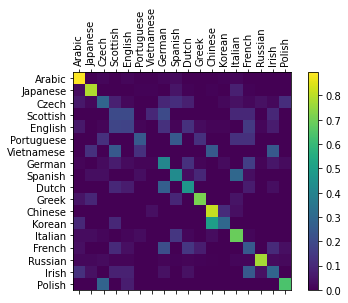

In [18]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
# Go through a bunch of examples and record which are correctly guessed
for category in all_categories:
    for line in category_lines_test[category]:
        line_tensor = lineToTensor(line)
        output = evaluate(rnn_Adam_2,line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
accuracy = 0
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    accuracy += confusion[i][i]
accuracy /= n_categories

# Displaying the average accuracy
print('Average Macro Accuracy = {:.2f}\n'.format(accuracy))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Task 2.3

TO DO - Enter Your Response here

1) After making the model complex By applying RELU activation on multiple levels to the RNN model there is a significant increase in accuracy of the  model.

2)The Complex RNN model with Adam with learning rate of 0.0001 performed much better in the test set than the Baseline RNN with Adam with learning rate of   0.001. 

3) The learning curve for Complex RNN is a steep one while, but the Complex RNN’s curve is better than the Baseline
RNN’s learning curve.





## [Task 3] Using LSTM [40 pts]

Replace the custom-built RNN for a standard LSTM layer. This may require you to do some significant changes to the network class and training functions.

1. [16 pts] Compare the learning curves for the baseline trained with Adam and the LSTM model trained with Adam as well. Train both models for only 50,000 iterations.
2. [16 pts] Evaluate the performance of both models on the test set.
3. [8 pts] Comment on the performance of both methods on the test set, and the shape of their learning curves.

### Task 3.1

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [73]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed]
class RNN_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):

    super(RNN_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
#LSTM
    self.lstm = nn.LSTM(input_size, hidden_size).to(device)
    self.hidden2Cat = nn.Linear(hidden_size, output_size).to(device)
    self.hidden = self.init_hidden()
  def forward(self, input):
    lstm_out, self.hidden = self.lstm(input, self.hidden)
    output = self.hidden2Cat(lstm_out[-1]) #many to one
    output = F.log_softmax(output, dim=1)
    return output
  def init_hidden(self):
    return (torch.zeros(1, 1, self.hidden_size).to(device),
            torch.zeros(1, 1, self.hidden_size).to(device))


In [74]:
criterion = nn.NLLLoss()
# If you set this too high, it might explode. If too low, it might not learn
learning_rate = 0.001
n_hidden = 128
lstm = RNN_LSTM(n_letters, n_hidden, n_categories) #LSTM model
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [76]:
def train_lstm(category_tensor, line_tensor):
  optimizer.zero_grad()
  lstm.hidden = lstm.init_hidden()
  output = lstm(line_tensor)[-1]
  loss = criterion(output.unsqueeze(0), category_tensor)
  loss.backward()
  optimizer.step()
  return output.unsqueeze(0), loss.item()

In [78]:
n_iters = 50000
print_every = 5000
plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_iterations = []
def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)
start = time.time()
for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
#print(line_tensor)
  output, loss = train_lstm(category_tensor.to(device), line_tensor.to(device))
  current_loss += loss
# Print iter number, loss, name and guess
  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '' if guess == category else ' (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' %
    (iter, iter / n_iters * 100, timeSince(start),
    loss, line, guess, correct))
# Add current loss avg to list of losses
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    all_iterations.append(iter)
    current_loss = 0

5000 10% (0m 12s) 0.9302 Bai / Chinese 
10000 20% (0m 25s) 0.5053 Ryu / Korean 
15000 30% (0m 37s) 0.4721 Romao / Portuguese 
20000 40% (0m 49s) 0.4011 Ramires / Portuguese 
25000 50% (1m 2s) 0.1361 De santigo / Portuguese 
30000 60% (1m 14s) 0.0065 Forakis / Greek 
35000 70% (1m 26s) 0.4428 Nieves / Spanish 
40000 80% (1m 39s) 0.0090 Meeuwsen / Dutch 
45000 90% (1m 51s) 0.0356 Rheem / Korean 
50000 100% (2m 4s) 0.4077 Granin / Russian 


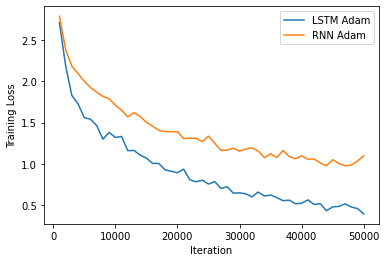

In [80]:
plt.figure()
plt.plot(all_iterations, all_losses,all_iterCt_Adam_2,all_losses_Adam_2)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend(['LSTM Adam','RNN Adam'])
plt.show()

### Task 3.2

Average Macro Accuracy = 0.47



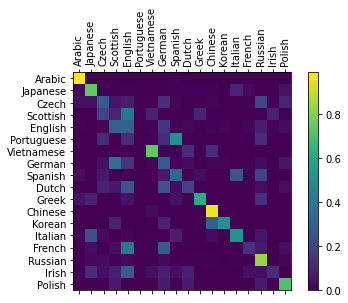

In [81]:
### TO DO - Enter Your Code here... You are welcome to add more cell if needed
confusion = torch.zeros(n_categories, n_categories)
# Just return an output given a line
def evaluate_lstm(line_tensor):
  lstm.hidden = lstm.init_hidden()
  output = lstm(line_tensor)
  return output
# Go through a bunch of examples and record which are correctly guessed
for category in all_categories:
  for line in category_lines_test[category]:
    line_tensor = lineToTensor(line)
    output = evaluate_lstm(line_tensor.to(device))
    output = output.unsqueeze(0)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
accuracy = 0
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()
  accuracy += confusion[i][i]
accuracy /= n_categories
# Displaying the average accuracy
print('Average Macro Accuracy = {:.2f}\n'.format(accuracy))
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

### Task 3.3

TO DO - Enter Your Response here

1) The LSTM model with Adam with learning rate of 0.001 performed better in the test set than the Baseline RNN with Adam which had a learning rate of 0.0001. 

2) The learning curve for LSTM Adam is much more steep than the baseline RNN with Adam.